# Importations

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time

# Utils

In [11]:
def plot_function(f):
    precision = 100000
    x_axis = np.linspace(-10, 10, precision).reshape((precision, 1))
    y_axis = f(x_axis)
    plt.figure(figsize=(20, 10))
    plt.xlim(-5.5, 2.5)
    plt.ylim(-5, 20)
    plt.grid()
    plt.plot(x_axis, y_axis)
    plt.show()

# Function

In [12]:
def f(x):
    y = (np.sin(10 * np.pi * x) / (2 * x)) + (x - 1)**4
    return y

In [13]:
def df(x):
    y = (10*np.pi*np.cos(10*np.pi*x) / 2*x) + (np.sin(10 * np.pi * x) * (0.5 * (-1/x**2))) + 4*x**3
    return y

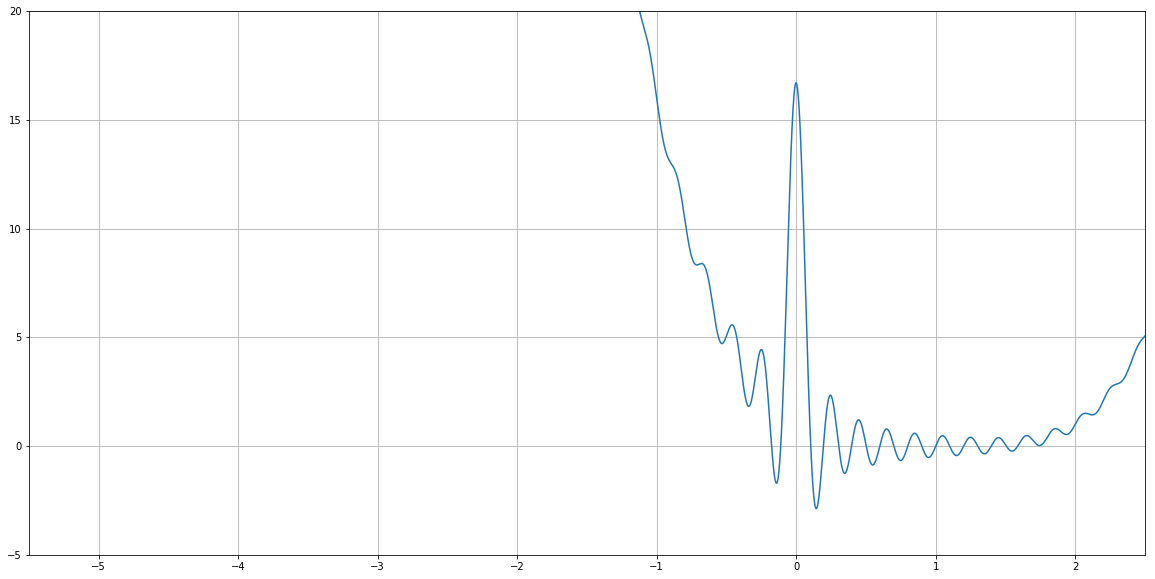

In [14]:
plot_function(f)

# Gradient Descent

Initialization : 1.7847659012070025
Time spend : 412.64986991882324 ms
Final value : 0.5711805738340546 -0.654816954976495


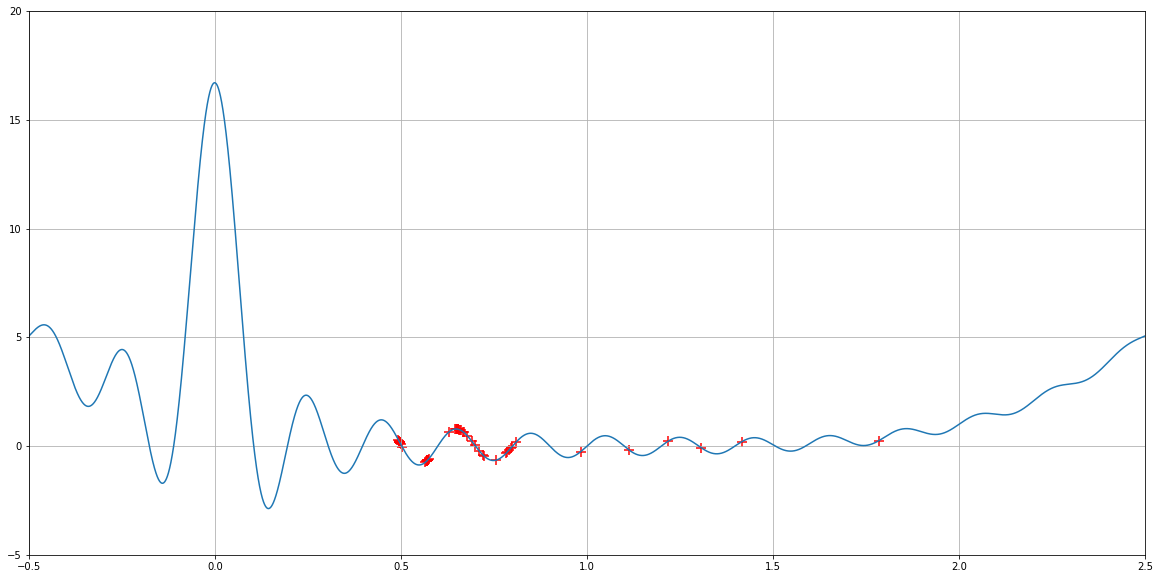

In [6]:
# Learning parameters
nb_epochs = 100000
learning_rate = 0.01

# Initialization
x0 = np.random.uniform(-0.5, 2.5)
x_list = [x0]
print('Initialization :', x0)

# Gradient descent
start = time.time()
for i in range(nb_epochs):
    dx = df(x0)
    x0 = x0 - learning_rate * dx
    x_list.append(x0)
end = time.time()
print('Time spend :', (end - start) * 1000, 'ms')
print('Final value :', x0, f(x0))

# Display result
x_list = np.array(x_list)
precision = 100000
x_axis = np.linspace(-10, 10, precision).reshape((precision, 1))
y_axis = f(x_axis)
plt.figure(figsize=(20, 10))
plt.xlim(-0.5, 2.5)
plt.ylim(-5, 20)
plt.grid()
plt.plot(x_axis, y_axis)
plt.scatter(x_list, f(x_list), s=100, c='r', marker='+')
plt.show()

# The CMA Evolution Strategy

## 0) Randomized Black Box Optimization

We consider black box search scenario, where we want to minimize an objective function

$$ f : R^n \to R \\ x \mapsto f(x) $$

The **objective** is to find one or more search points (candidate solutions), $x \in R^n$, with a function value, $f(x)$, as small as possible. Black box optimization refers to the situation where function values of evaluated search points are the only accessible information on $f$. The search points to be evaluated can be freely chosen. We define the **search costs** as the number of executed function evaluations.

Randomized black box search :
- Initialize distribution parameter $\theta^{(0)}$
- For generation g = 0, 1, 2, ...
    - Sample $\lambda$ independent points from distribution $P(x | \theta^{(g)}) \to x_1, ... x_\lambda$
    - Evaluate the sample $x_1$, ... $x_\lambda$ on $f$
    - Update parameters $\theta^{(g+1)} = F_\theta (\theta^{(g)}, (x_1, f(x_1)), ... (x_\lambda, f(x_\lambda)))$
    - Break, if termination criterion met

In the CMA Evolution Strategy, the search distribution P is a multivariate normal distribution.

Randomized search algorithms are regarded to be robust in a rugged search landscape, which can comprise discontinuities, (sharp) ridges, or local optima. The covariance matrix adaptation (CMA) in particular is designed to tackle, additionally, ill-conditioned and non-separable problems.

## 1) Basic Equation : Sampling

In the CMA Evolution Strategy, a population of new search points (individuals, offspring) is generated by sampling a multivariate normal distribution. The basic equation for sampling the search points, for generation number g= 0, 1, 2, ... is

$$ x_k^{(g+1)} \sim m^{(g)} + \sigma^{(g)} N(0, C^{(g)}) = N(m^{(g)}, (\sigma^{(g)})^2 C^{(g)})$$

How to calculate $m^{(g+1)}$, $C^{(g+1)}$, and $\sigma^{(g+1)}$ for the next generation g + 1. The next three sections will answer these questions, respectively.

## 2) Selection and Recombination : Moving the Mean

The new mean is the weighted average of $\mu$ best points from the sample.

The measure $\mu_{eff}$ is the variance effective selection mass :

$$\mu_{eff} = \frac{1}{\sum_{i=1}^\mu w_i^2}$$

We can observe that $1 \leq \mu_{eff} \leq \mu$ (usually $\mu_{eff} = \lambda / 4$).

**Final equation :**

$$ m^{(g+1)} =  c_m \sum_{i=1}^\mu w_i x^{(g+1)}_{i:\lambda} + (1 - c_m) m^{(g)} $$

$c_m \leq 1$ is the learning rate, usually set to 1. Hence $ m^{(g+1)} = \sum_{i=1}^\mu w_i x^{(g+1)}_{i:\lambda}$. Choosing $c_m \leq 1$ can be advantageous on noisy functions.

## 3) Adapting the Covariance Matrix

### a) Estimating the Convariance Matrix From Scratch

We assume that the population contains enough information to reliably estimate a covariance matrix from it. We also assume that $\sigma^{(g)} = 1$ (true except for a constant factor).

We can estimate the original covariance matrix $C^{(g)}$ using the sampled population via the empirical covariance matrix, which is an unbiased estimator of $C^{(g)}$ :

$$ C^{(g+1)}_{emp} = \frac{1}{\lambda - 1} \sum_{i=1}^\lambda (x_i^{(g+1)} - \frac{1}{\lambda} \sum_{j=1}^\lambda x_j^{(g+1)}) (x_i^{(g+1)} - \frac{1}{\lambda} \sum_{j=1}^\lambda x_j^{(g+1)})^T $$

There exists a slightly different approach to estimate $C^{(g)}$ :

$$ C^{(g+1)}_{\lambda} = \frac{1}{\lambda} \sum_{i=1}^\lambda (x_i^{(g+1)} - m^{(g)}) (x_i^{(g+1)} - m^{(g)})^T $$

To estimate a "better" covariance matrix, we can use :

$$ C^{(g+1)}_{\mu} = \sum_{i=1}^\mu w_i (x_{i:\lambda}^{(g+1)} - m^{(g)}) (x_{i:\lambda}^{(g+1)} - m^{(g)})^T $$

The matrix $C_\mu^{(g+1)}$ is an estimator for the distribution of selected steps. Sampling from it tends to reproduce selected, i.e. successful steps, giving a justification for what a "better" covariance matrix means.

For these equations to be reliable estimators, we need $\mu_{eff} = 10n$. The next step is to avoid this restriction on $\mu_{eff}$.

### b) Rank-$\mu$-Update

To achieve fast search, the population size $\lambda$ must be small. Because $\mu_{eff} = \lambda / 4$ also $\mu_{eff}$ must be small and then it is not possible to get a reliable estimator for a good covariance matrix. As a remedy, information from previous generations is used additionally.

To do that, we calculate an exponentially weighted moving average over sampled generations :

$$ C^{(g+1)} = (1 - c_\mu) C^{(g)} + c_\mu \frac{1}{\sigma^{(g)^2}} C_\mu^{(g+1)} = (1 - c_\mu) C^{(g)} + c_\mu \sum_{i=1}^\mu w_i y^{(g+1)}_{i:\lambda} (y^{(g+1)}_{i:\lambda})^T $$

A first order approximation for a good choice is $c_\mu = \mu_{eff} / n^2 $.

### c) Rank-One-Update

In the first section, we started by estimating the complete covariance matrix from scratch, using all selected steps from a single generation. We now take an opposite viewpoint. We repeatedly update the covariance matrix in the generation sequence using a single  selected step only.


Using previous equations, we have :

$$ C^{(g+1)} = (1 - c_1) C^{(g)} + c_1 y^{(g+1)} (y^{(g+1)})^T $$

But the problem is that the sign information is lost when calculating $C^{(g+1)}$. To reintroduce it, a so-called evolution path is constructed. An evolution path is a sequence of successive steps, this summation is referred to as a cumulation. It looks like $ \frac{m^{(g+1)} - m^{(g)}}{\sigma^{(g)}} + \frac{m^{(g)} - m^{(g-1)}}{\sigma^{(g-1)}} + \frac{m^{(g-1)} - m^{(g-2)}}{\sigma^{(g-2)}} $, but in practice we use an exponentially weighted moving average :

$$ p_c^{(g+1)} = (1 - c_c) p_c^{(g)} + c_c \frac{m^{(g+1)} - m^{(g)}}{\sigma^{(g)}} $$

The rank-one-update is then :

$$ C^{(g+1)} = (1 - c_1) C^{(g)} + c_1 p_c^{(g+1)} (p_c^{(g+1)})^T $$

$c_1 = 2 / n^2$

### d) Combining rank-$\mu$-update and cumulation

**Final equation :**

$$ C^{(g+1)} = (1 - c_1 - c_\mu \sum_j w_j) C^{(g)} + c_1 p_c^{(g+1)} (p_c^{(g+1)})^T + c_\mu \sum_{i=1}^\mu w_i y^{(g+1)}_{i:\lambda} (y^{(g+1)}_{i:\lambda})^T $$

If $c_1 = 0$, it is rank-$\mu$-update. If $c_\mu = 0$, it is rank-one-update.

The equation combines the advantages of rank-$\mu$-update and rank-one-update. On the one hand, the information from the entire population is used efficiently by the so-called rank-$\mu$-update. On the other hand, information of correlations between generations is exploited by using the evolution path for the rank-one-update. The former is important in large populations, the latter is particularly important in small populations.

## 4) Step-size control

$$ p_\sigma^{(g+1)} = (1 - c_\sigma) p_\sigma^{(g)} + c_\sigma C^{(g)^{-\frac{1}{2}}}\frac{m^{(g+1)} - m^{(g)}}{\sigma^{(g)}} $$

**Final equation :**

$$ \sigma^{(g+1)} = \sigma^{(g)} exp( \frac{c_\sigma}{d_\sigma} (\frac{||p_\sigma^{(g+1)}||}{E || N(0, I) ||} - 1) ) $$

## CMA-ES algorithm summary :

$$ m^{(g+1)} =  c_m \sum_{i=1}^\mu w_i x^{(g+1)}_{i:\lambda} + (1 - c_m) m^{(g)} $$

$$ C^{(g+1)} = (1 - c_1 - c_\mu \sum_j w_j) C^{(g)} + c_1 p_c^{(g+1)} (p_c^{(g+1)})^T + c_\mu \sum_{i=1}^\mu w_i y^{(g+1)}_{i:\lambda} (y^{(g+1)}_{i:\lambda})^T $$

$$ \sigma^{(g+1)} = \sigma^{(g)} exp( \frac{c_\sigma}{d_\sigma} (\frac{||p_\sigma^{(g+1)}||}{E || N(0, I) ||} - 1) ) $$

aside :

$$ y_{i:\lambda}^{(g+1)} = (x_{i:\lambda}^{(g+1)} - m^{(g)}) / \sigma^{(g)} $$

$$ p_c^{(g+1)} = (1 - c_c) p_c^{(g)} + c_c \frac{m^{(g+1)} - m^{(g)}}{\sigma^{(g)}} $$

$$ p_\sigma^{(g+1)} =  $$

In [42]:
# CMA-ES algorithm

# Initialize parameters
m = 0
sigma = 1
lamb = 10
mu = 2

nb_gen = 100
n = 1
w = 1 / lamb

C = np.identity(n)
pc = 0
psigma = 0

"""
cc = 4 / n
csigma = 4 / n
c1 = 2 / n**2
muw = 0.3 * lamb
cmu = muw / n**2
dsigma = 1 + np.sqrt(muw / n)
"""

cc = 0.1
csigma = 0.1
c1 = 0.01
muw = 0.3*lamb
cmu = muw
dsigma = 1 + np.sqrt(muw)

# For generation g = 0, 1, 2 ...
for g in range(nb_gen):
    
    # Sampling
    x = np.random.randn(lamb) * C**(0.5) * sigma + m
    print(x)
    
    # Evaluate
    fitness_scores = f(x)
    res = sorted(zip(fitness_scores, x))
    res = np.array(res)
    yilamb = res[:mu].T[1].T
    yilamb = np.array(yilamb)
    yw = np.mean(yilamb)
    print(yw)
    
    # Update parameters
    m = m + sigma * yw
    pc = (1 - cc) * pc + cc * np.sqrt(muw) * yw
    psigma = (1 - csigma) * psigma + np.sqrt(1 - (1 - csigma)**2) * np.sqrt(muw) * C**(-0.5) * yw
    C = (1 - c1 - cmu) * C + c1 * np.dot(pc, pc.T) + cmu * np.dot(yilamb, yilamb.T)
    sigma = sigma * np.exp((csigma / 2 * dsigma) * ((np.linalg.norm(psigma)**2 / n) - 1))

[[-1.44499118 -0.68453069  0.59152148 -1.36010437 -1.01633533  0.39524397
  -1.15355721 -1.91355184  0.44876464  0.65346759]]
3.8544285042676694
[[ 40.69589959  53.19909607  41.70919012  35.93353325  -2.54640813
   -7.05712407  -7.10202744  23.37652999  -3.01327509 -24.16122733]]
3712145.9753776365
[[-inf -inf  inf -inf  inf  inf -inf -inf  inf  inf]]
nan
[[nan nan nan nan nan nan nan nan nan nan]]
nan
[[nan nan nan nan nan nan nan nan nan nan]]
nan
[[nan nan nan nan nan nan nan nan nan nan]]
nan
[[nan nan nan nan nan nan nan nan nan nan]]
nan
[[nan nan nan nan nan nan nan nan nan nan]]
nan
[[nan nan nan nan nan nan nan nan nan nan]]
nan
[[nan nan nan nan nan nan nan nan nan nan]]
nan
[[nan nan nan nan nan nan nan nan nan nan]]
nan
[[nan nan nan nan nan nan nan nan nan nan]]
nan
[[nan nan nan nan nan nan nan nan nan nan]]
nan
[[nan nan nan nan nan nan nan nan nan nan]]
nan
[[nan nan nan nan nan nan nan nan nan nan]]
nan
[[nan nan nan nan nan nan nan nan nan nan]]
nan
[[nan nan nan nan 

/home/ridouane/anaconda3/envs/Predict-poverty/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sin
  


Time spend : 4937.123775482178 ms
Final value : 0.1437791738277379 -2.8738989416296277


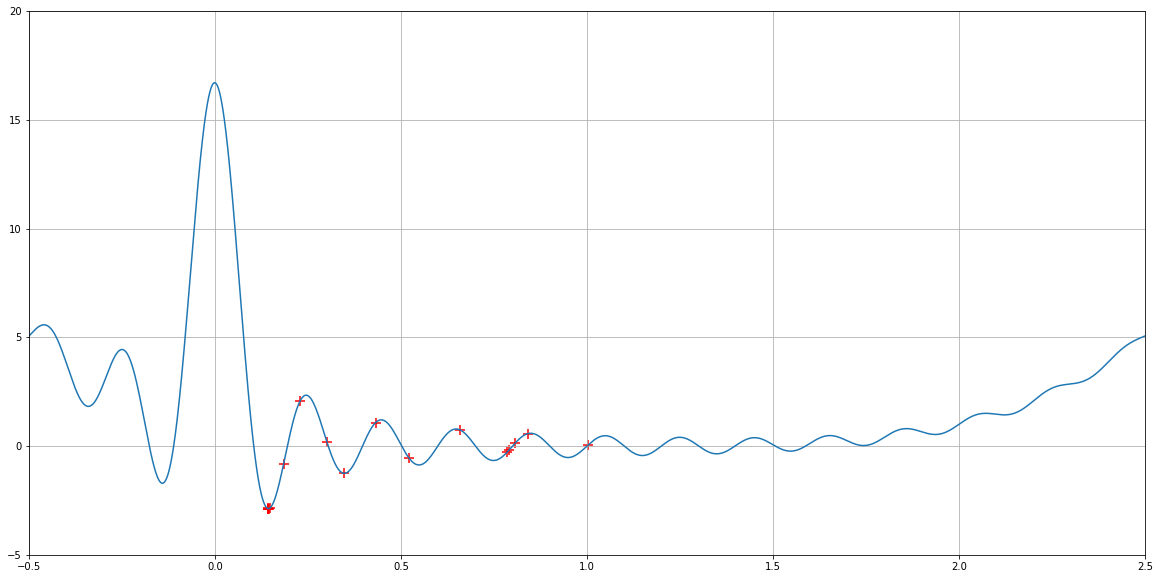

In [185]:
# Learning parameters
nb_pop = 50
prop_chosen = 0.25
nb_epochs = 100000

# Initialization
x0 = np.random.uniform(-10, 10)
mu0, sig0 = x0, 1
x_list = []
x_list.append(mu0)

# Evolution strategy
start = time.time()
for i in range(nb_epochs):
    # Generate population
    gen0 = np.random.randn(nb_pop)*np.sqrt(sig0) + mu0
    
    # Evaluate population
    fitness_scores = f(gen0)
    
    # Get best individuals
    res = sorted(zip(fitness_scores, gen0))
    nb_survivor = int(prop_chosen * len(gen0))
    res = res[:nb_survivor]
    res = np.array(res)
    x0_best = res[:, 1]
    
    # Update mean and variance of the next generation
    tmp = mu0
    mu0 = np.mean(x0_best)
    sig0 = np.sum((x0_best - tmp)**2) / nb_survivor
    x_list.append(mu0)
end = time.time()
print('Time spend :', (end - start) * 1000, 'ms')
print('Final value :', mu0, f(mu0))

# Display result
x_list = np.array(x_list)
precision = 100000
x_axis = np.linspace(-10, 10, precision).reshape((precision, 1))
y_axis = f(x_axis)
plt.figure(figsize=(20, 10))
plt.xlim(-0.5, 2.5)
plt.ylim(-5, 20)
plt.grid()
plt.plot(x_axis, y_axis)
plt.scatter(x_list, f(x_list), s=100, c='r', marker='+')
plt.show()

# Bibliographie

Gradient Descent theory : ml.pdf  
Evolution Strategies introduction :  
http://blog.otoro.net/2017/10/29/visual-evolution-strategies/  
https://arxiv.org/pdf/1604.00772.pdf  
http://www.cmap.polytechnique.fr/~nikolaus.hansen/gecco2012-CMA-ES-tutorial.pdf  